In [2]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 8.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 7.7 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load the dataset (Change path to the correct location of your dataset)
combined_data = pd.read_csv('/work/festusedward-n/Dataset_TZ_KM/combined_data_30.csv')

# 2. Separate features (X) and target (y)
X = combined_data.drop(columns=['label', 'id', 'timestamp'], errors='ignore')  # Drop label, id, and timestamp
y = combined_data['label']  # Label column (Benign = 0, Attack = 1)

# 3. Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns

# Encode each categorical column
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

# 4. Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Apply SMOTE for balancing the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# 6. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 7. Instantiate the XGBoost model
model_xgb = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42, 
    scale_pos_weight=np.sum(y == 0) / np.sum(y == 1)  # Adjust for class imbalance
)

# 8. Fit the model to the training data
model_xgb.fit(X_train, y_train)

# 9. Predict using the test data
y_pred_xgb = model_xgb.predict(X_test)

# 10. Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# 11. Optionally, you can save the model for future use
# model_xgb.save_model("xgb_model.json")



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50408
           1       1.00      1.00      1.00     50551

    accuracy                           1.00    100959
   macro avg       1.00      1.00      1.00    100959
weighted avg       1.00      1.00      1.00    100959

Confusion Matrix:
[[50408     0]
 [    0 50551]]


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

# 1. Load the dataset (Change path to the correct location of your dataset)
combined_data = pd.read_csv('/work/festusedward-n/Dataset_TZ_KM/combined_data_30.csv')

# 2. Separate features (X) and target (y)
X = combined_data.drop(columns=['label', 'id', 'timestamp'], errors='ignore')  # Drop label, id, and timestamp
y = combined_data['label']  # Label column (Benign = 0, Attack = 1)

# 3. Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns

# Encode each categorical column
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

# 4. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 6. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# 7. Initialize XGBoost Classifier
model_xgb = xgb.XGBClassifier(random_state=42)

# 8. Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train_res)

# Get the best parameters from the GridSearch
best_params = grid_search.best_params_
print("Best parameters from GridSearchCV:", best_params)

# 9. Evaluate model with cross-validation
cross_val_score(model_xgb, X_train_scaled, y_train_res, cv=5, scoring='accuracy')

# 10. Train the model with the best parameters
best_model = grid_search.best_estimator_

# 11. Predict and evaluate the model
y_pred = best_model.predict(X_test_scaled)

# 12. Print the classification report and confusion matrix
print("Classification Report (Test Data):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_pred))



Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rat

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [65624, 250]

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] 

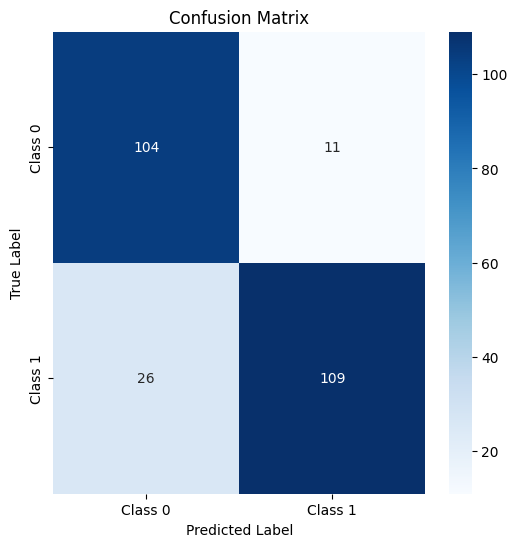

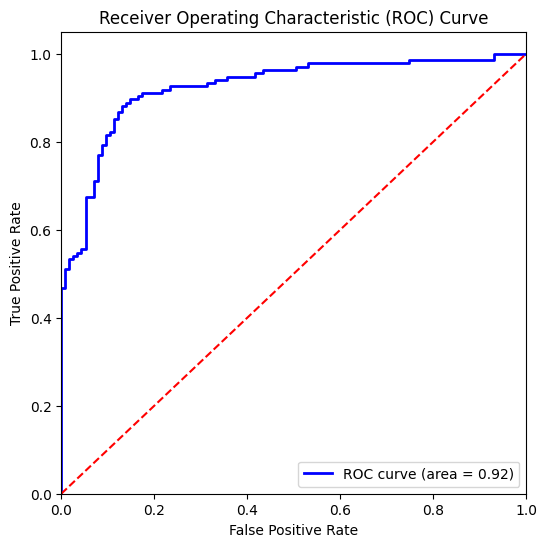

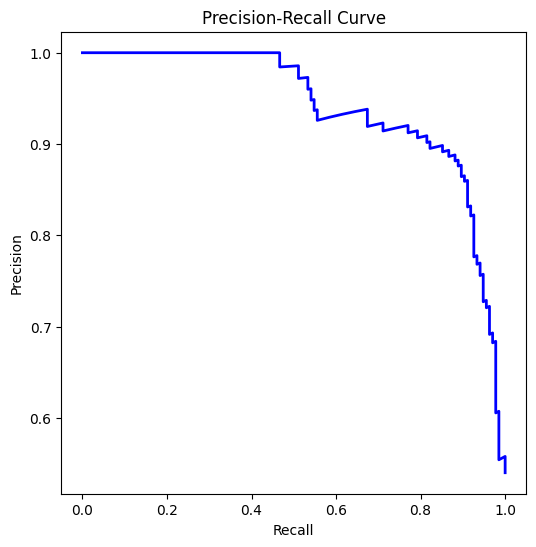

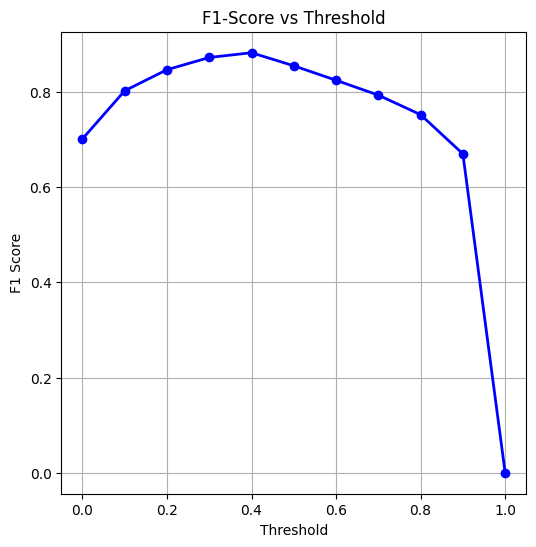

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix



# Predict probabilities for ROC and Precision-Recall
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# F1-Score vs Threshold Plot
f1_scores = []
thresholds = np.arange(0.0, 1.1, 0.1)

for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))

plt.figure(figsize=(6, 6))
plt.plot(thresholds, f1_scores, marker='o', color='b', lw=2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1-Score vs Threshold')
plt.grid(True)
plt.show()


In [5]:
pip install numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.6 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


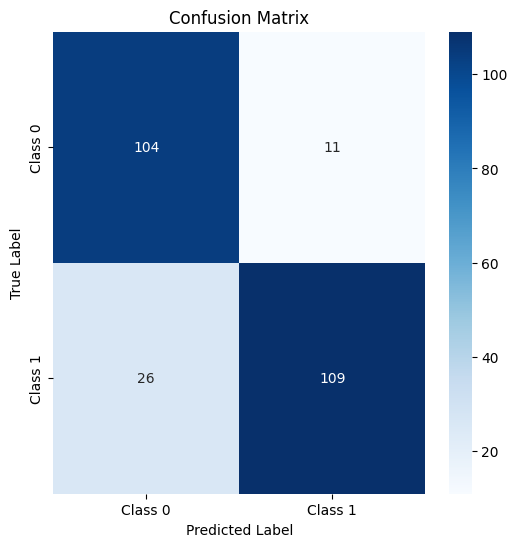

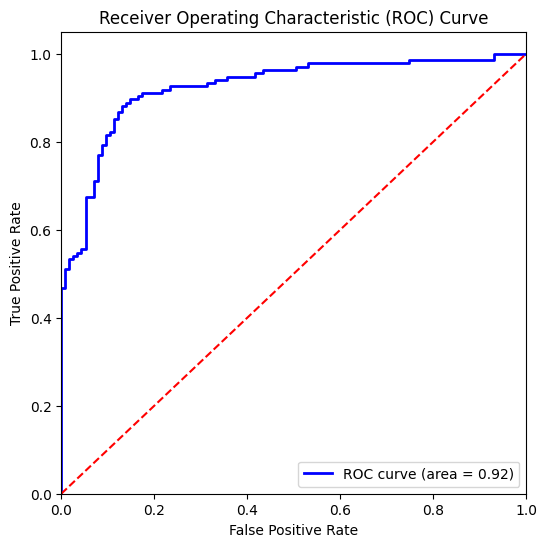

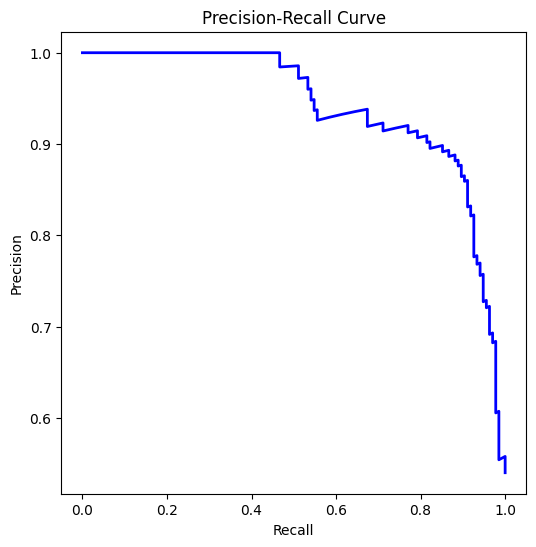

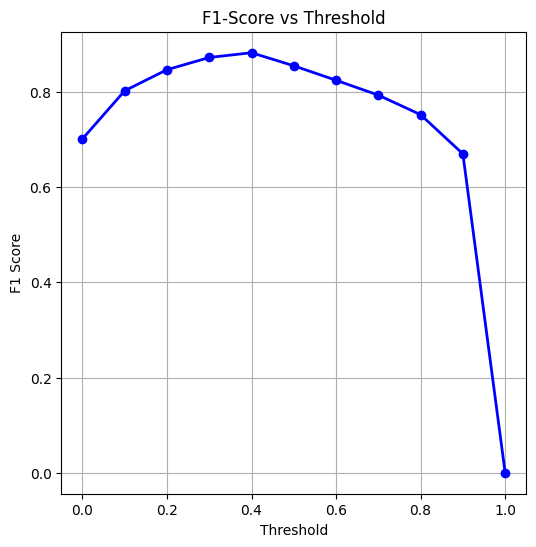

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Generating some sample data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit a simple logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for ROC and Precision-Recall
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# F1-Score vs Threshold Plot
f1_scores = []
thresholds = np.arange(0.0, 1.1, 0.1)

for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))

plt.figure(figsize=(6, 6))
plt.plot(thresholds, f1_scores, marker='o', color='b', lw=2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1-Score vs Threshold')
plt.grid(True)
plt.show()


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_d

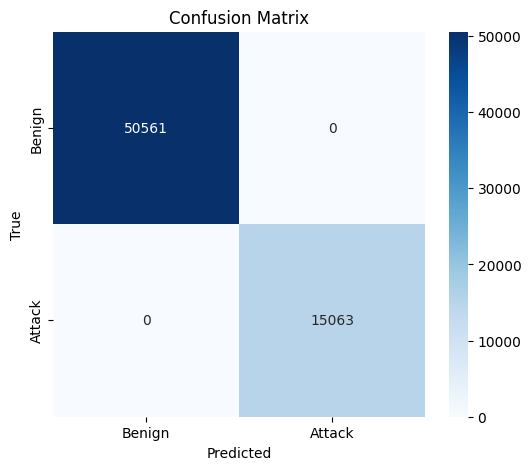

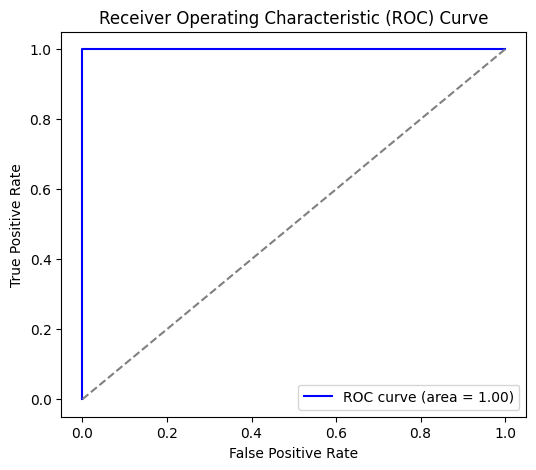

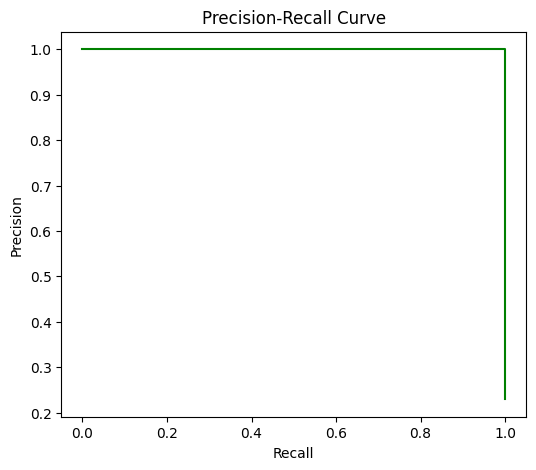

<Figure size 1000x600 with 0 Axes>

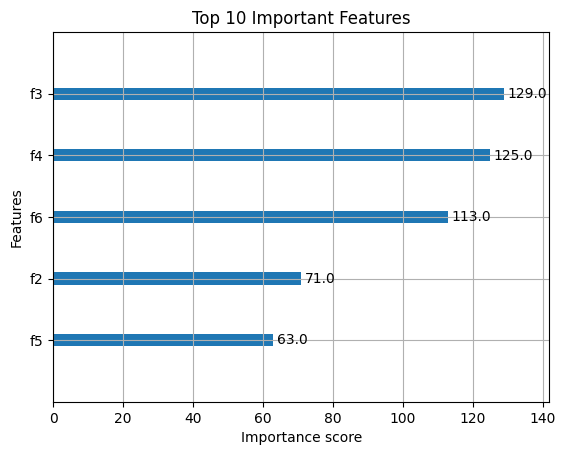

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset (Change path to the correct location of your dataset)
combined_data = pd.read_csv('/work/festusedward-n/Dataset_TZ_KM/combined_data_30.csv')

# 2. Separate features (X) and target (y)
X = combined_data.drop(columns=['label', 'id', 'timestamp'], errors='ignore')  # Drop label, id, and timestamp
y = combined_data['label']  # Label column (Benign = 0, Attack = 1)

# 3. Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns

# Encode each categorical column
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

# 4. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 6. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# 7. Initialize XGBoost Classifier
model_xgb = xgb.XGBClassifier(random_state=42)

# 8. Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train_res)

# Get the best parameters from GridSearch
best_params = grid_search.best_params_
print("Best parameters from GridSearchCV:", best_params)

# 9. Train the model with the best parameters
best_model = grid_search.best_estimator_

# 10. Predict and evaluate the model
y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC and Precision-Recall

# 11. Print the classification report and confusion matrix
print("Classification Report (Test Data):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Test Data):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 12. Plot Confusion Matrix as Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 13. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 14. Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# 15. Plot Feature Importance (Optional)
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Important Features')
plt.show()


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_d

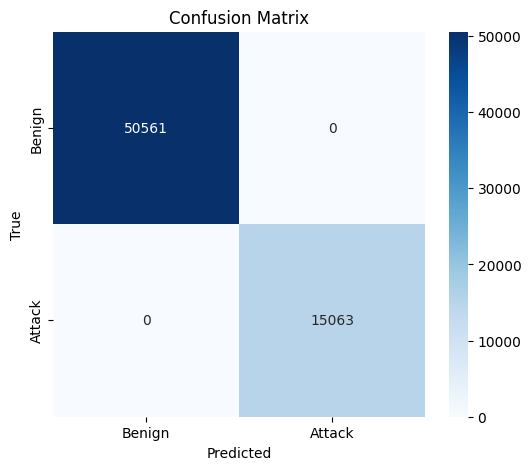

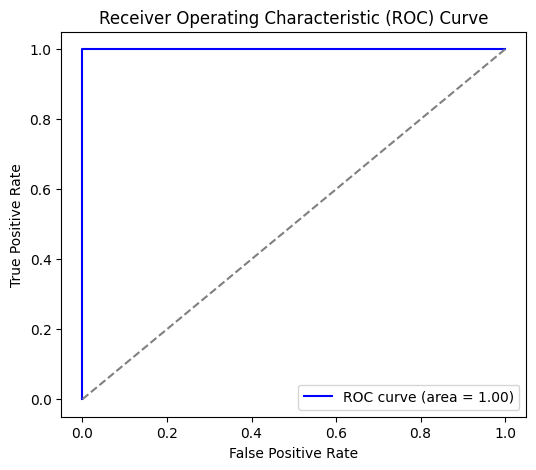

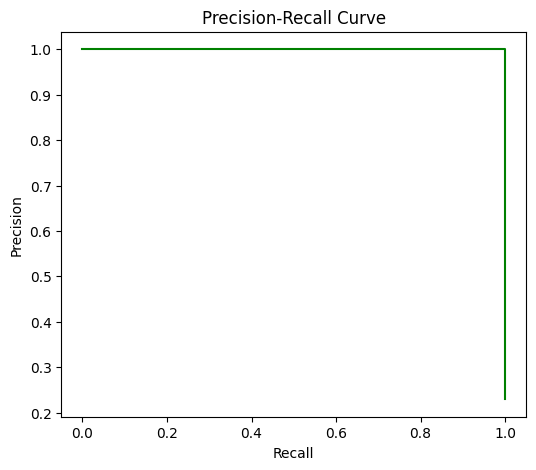

<Figure size 1000x600 with 0 Axes>

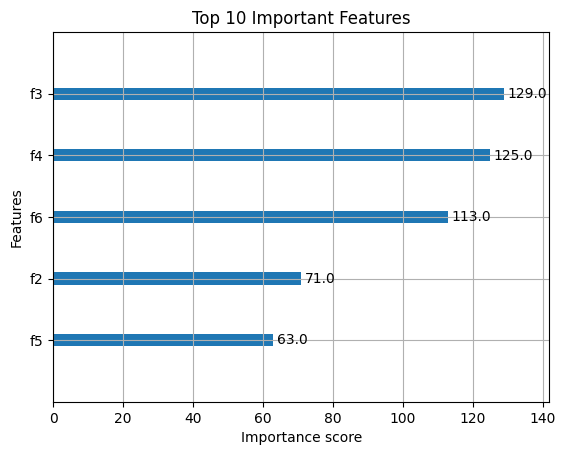

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total ti

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset (Change path to the correct location of your dataset)
combined_data = pd.read_csv('/work/festusedward-n/Dataset_TZ_KM/combined_data_30.csv')

# 2. Separate features (X) and target (y)
X = combined_data.drop(columns=['label', 'id', 'timestamp'], errors='ignore')  # Drop label, id, and timestamp
y = combined_data['label']  # Label column (Benign = 0, Attack = 1)

# 3. Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns

# Encode each categorical column
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

# 4. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 6. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# 7. Initialize XGBoost Classifier
model_xgb = xgb.XGBClassifier(random_state=42)

# 8. Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train_res)

# Get the best parameters from GridSearch
best_params = grid_search.best_params_
print("Best parameters from GridSearchCV:", best_params)

# 9. Train the model with the best parameters
best_model = grid_search.best_estimator_

# 10. Predict and evaluate the model
y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC and Precision-Recall

# 11. Print the classification report and confusion matrix
print("Classification Report (Test Data):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Test Data):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 12. Plot Confusion Matrix as Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Save Confusion Matrix Plot
plt.savefig('confusion_matrix.png')
plt.savefig('confusion_matrix.pdf')

plt.show()

# 13. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save ROC Curve Plot
plt.savefig('roc_curve_mouse.png')
plt.savefig('roc_curve_mouse.pdf')

plt.show()

# 14. Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Save Precision-Recall Curve Plot
plt.savefig('precision_recall_curve_mouse.png')
plt.savefig('precision_recall_curve_mouse.pdf')

plt.show()

# 15. Plot Feature Importance (Optional)
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Important Features')

# Save Feature Importance Plot
plt.savefig('feature_importance_mouse.png')
plt.savefig('feature_importance_mouse.pdf')

plt.show()
